In [1]:
import cv2
import numpy as np
import os
import util
from DDPM_Net import Model
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import random
from torch.utils.data import DataLoader, Dataset

In [2]:
class trainDataset(Dataset):
    data_dir = "C:\\Users\\Lenovo\\Desktop\\Diffusion Model\\OCT_DDPM\\traindata_clean\\"

    def __init__(self):
        super().__init__()
        self.vol_dir = []
        self.data = []
        self.data_dir = "C:\\Users\\Lenovo\\Desktop\\Diffusion Model\\OCT_DDPM\\traindata_clean\\"

        for folder in os.listdir(trainDataset.data_dir):
            img = cv2.imread(trainDataset.data_dir+folder, cv2.IMREAD_GRAYSCALE)
            im = np.zeros([256, 256], dtype=np.float32)
            im[:, :] = util.ImageRescale(img, [-1, 1])
            self.data.append(im)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        x = torch.tensor(x).type(torch.FloatTensor)
        x = x[None, :, :]
        return x


def load_train_data(*, batch_size):
    dataset = trainDataset()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader


In [3]:
def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):
    def sigmoid(x):
        return 1 / (np.exp(-x) + 1)

    if beta_schedule == "quad":
        betas = (
            np.linspace(
                beta_start ** 0.5,
                beta_end ** 0.5,
                num_diffusion_timesteps,
                dtype=np.float64,
            )
            ** 2
        )
    elif beta_schedule == "linear":
        betas = np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "const":
        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1.0 / np.linspace(
            num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "sigmoid":
        betas = np.linspace(-6, 6, num_diffusion_timesteps)
        betas = sigmoid(betas) * (beta_end - beta_start) + beta_start
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (num_diffusion_timesteps,)
    return betas
def noise_estimation_loss(model,
                          x0:torch.Tensor, 
                          t:torch.LongTensor,
                          e:torch.Tensor,
                          b:torch.Tensor,
                          keepdim=False):
    a = torch.cumprod(1-b,dim=0).index_select(0, t).view(-1, 1, 1, 1).to(device)
    x = x0 * a.sqrt() + e * (1.0 - a).sqrt()
    output = model(x, t.float())
    if keepdim:
        return (e - output).square().sum(dim=(1, 2, 3))
    else:
        return (e - output).square().sum(dim=(1, 2, 3)).mean(dim=0)


def model_predict(x0, betas, t, *, status='train', transpose=True):
    with torch.no_grad():
        a = torch.cumprod(1-betas,dim=0)
        a_t = a[t].to(device)
        e = torch.randn_like(x0).to(device)
        
        if status == 'train':
            xt = torch.sqrt(1-a_t)*e+torch.sqrt(a_t)*x0  #扩散后的不清晰图象xt
        elif status == 'test':
            xt = x0
        else:
            print('status unspecified.')
        
        pred_e = model(xt, torch.from_numpy(np.array([T])).to(device))
        x0_pred = 1/torch.sqrt(a_t)*xt-torch.sqrt(1-a_t)/torch.sqrt(a_t)*pred_e #去除噪声后预测的x0
        
        if transpose:
            x0_show = np.transpose(x0[0,0,:,:].detach().cpu().numpy())
            x0_pred_show = np.transpose(x0_pred[0,0,:,:].detach().cpu().numpy())
            xt_show = np.transpose(xt[0,0,:,:].detach().cpu().numpy())
            
        else:
            x0_show = x0[0,0,:,:].detach().cpu().numpy()
            x0_pred_show = x0_pred[0,0,:,:].detach().cpu().numpy()
            xt_show = xt[0,0,:,:].detach().cpu().numpy()

    return x0_show, x0_pred_show, xt_show


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Lenovo\\Desktop\\Diffusion Model\\OCT_DDPM\\traindata_clean\\'

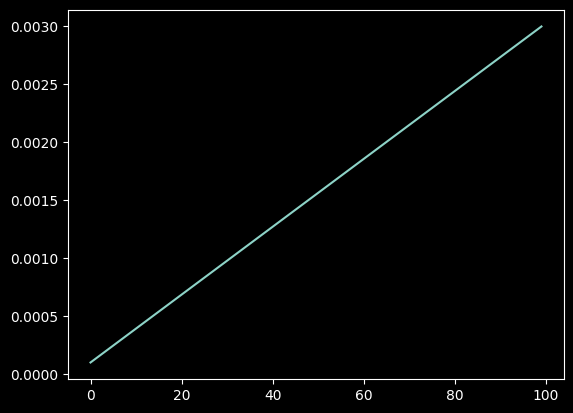

In [4]:
T = 100
gpu = 1
n_epoch = 10
device = torch.device("cuda:0" if( torch.cuda.is_available() and gpu>0 ) else "cpu")

beta_schedule = get_beta_schedule('linear',
                                  beta_start=0.0001,
                                  beta_end=0.003,
                                  num_diffusion_timesteps=T)
plt.plot(beta_schedule)
beta_schedule = torch.from_numpy(beta_schedule).float().to(device)
model = Model().to(device)
lr = 1e-4
optimizer = optim.Adam(model.parameters(),lr=lr,betas=(0.5,0.999))
scheduler = StepLR(optimizer,step_size=5,gamma=0.5)

train_data = load_train_data(batch_size=2)

Epoch: 1. Loss value: 59886.7930: 100%|██████████| 6/6 [00:26<00:00,  4.42s/it]

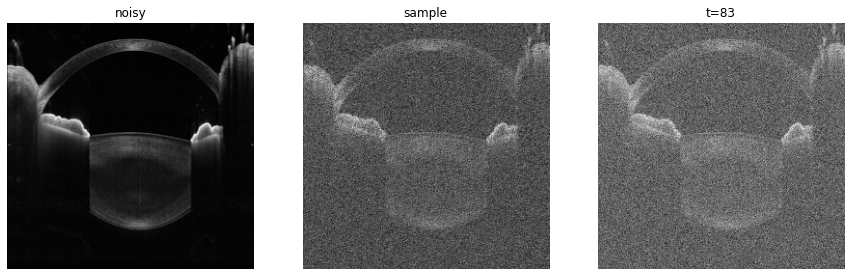

Epoch: 2. Loss value: 46897.1094: 100%|██████████| 6/6 [00:27<00:00,  4.47s/it]

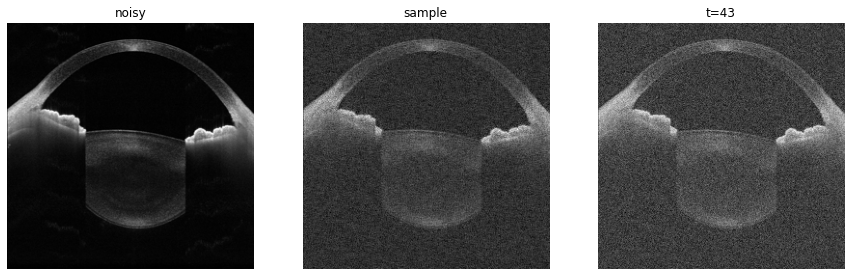

Epoch: 3. Loss value: 40801.0117: 100%|██████████| 6/6 [00:26<00:00,  4.38s/it]

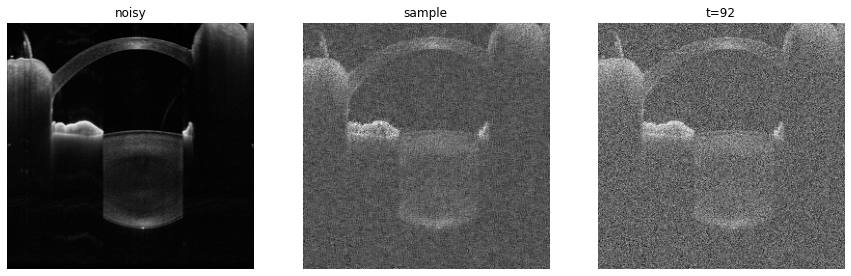

Epoch: 4. Loss value: 15966.2949: 100%|██████████| 6/6 [00:28<00:00,  4.73s/it]

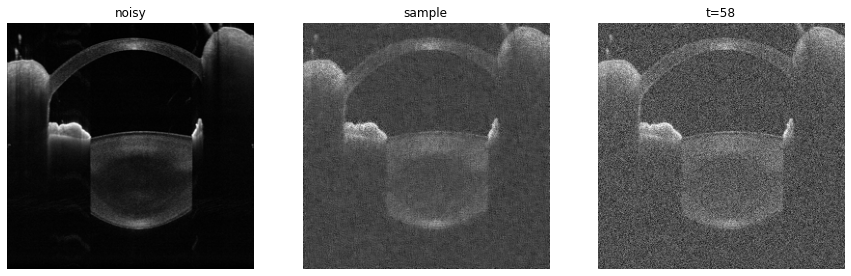

Epoch: 5. Loss value: 17731.6699: 100%|██████████| 6/6 [00:27<00:00,  4.60s/it]

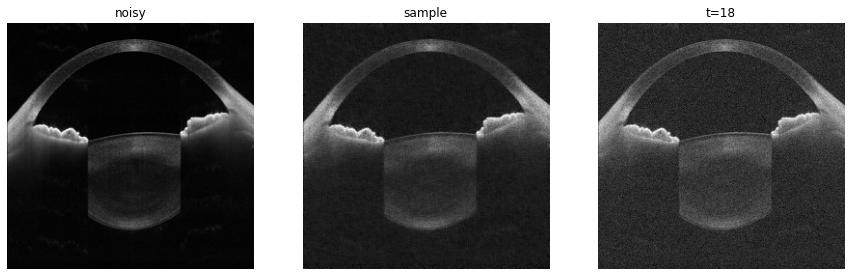

Epoch: 6. Loss value: 13277.7617: 100%|██████████| 6/6 [00:34<00:00,  5.23s/it]

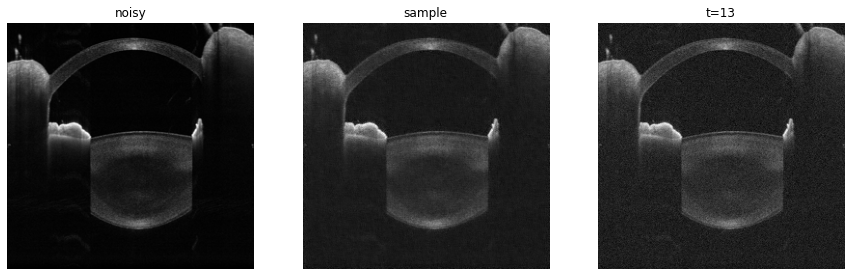

Epoch: 7. Loss value: 12639.4414: 100%|██████████| 6/6 [00:31<00:00,  5.28s/it]

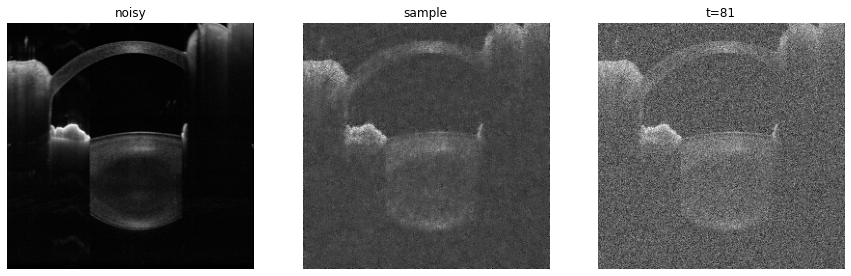

Epoch: 8. Loss value: 11863.8555: 100%|██████████| 6/6 [00:30<00:00,  5.00s/it]

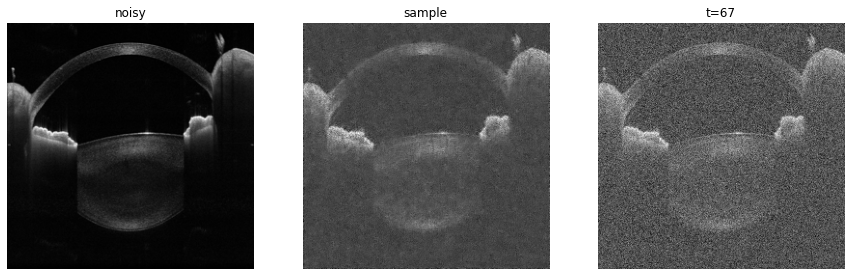

Epoch: 9. Loss value: 15649.1611: 100%|██████████| 6/6 [00:31<00:00,  5.36s/it]

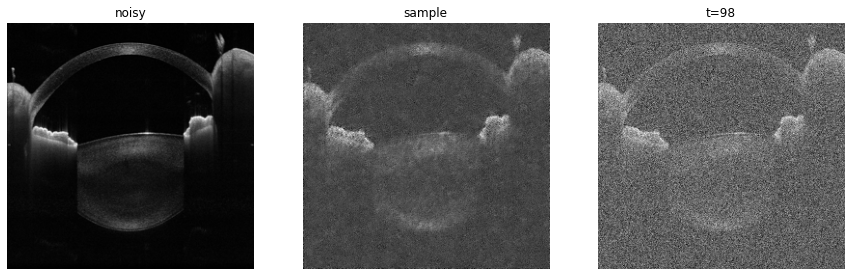

Epoch: 10. Loss value: 22419.1289: 100%|██████████| 6/6 [00:33<00:00,  5.58s/it]

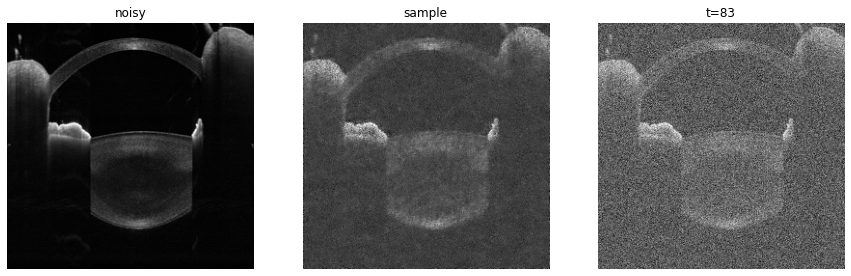

Epoch: 10. Loss value: 22419.1289: 100%|██████████| 6/6 [00:35<00:00,  5.99s/it]


In [ ]:
for epoch in range(n_epoch):
    values = range(len(train_data))
    with tqdm(total=len(values)) as pbar:
        for step, x in enumerate(train_data):
            
            model.train()
            
            x = x.to(device)
            e = torch.randn_like(x).to(device)
            b = beta_schedule
            
            n = x.size(0)  # batch_size
            t = torch.randint(low=0, high=T, size=(n//2 + 1,))
            t = torch.cat([t,T-t-1], dim=0)[:n].to(device)
            
            loss = noise_estimation_loss(model, x, t, e, b)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            pbar.update(1)
            pbar.set_description('Epoch: %d. Loss value: %.4f' % (epoch+1,loss))
            
            if step % (len(train_data)-1) == 0 and step != 0:
                timestep = random.randint(1,T-1)
                x0,x_pred,xt = model_predict(x,b,timestep,status='train',transpose=False)
                
                plt.figure(figsize=(15,6))
                plt.subplot(1,3,1),plt.imshow(x0[:,:500],cmap='gray'),plt.axis('off'),plt.title('noisy')
                plt.subplot(1,3,2),plt.imshow(x_pred[:,:500],cmap='gray'),plt.axis('off'),plt.title('sample')
                plt.subplot(1,3,3),plt.imshow(xt[:,:500],cmap='gray'),plt.axis('off'),plt.title('t={}'.format(timestep))
                plt.show()
                
        if epoch % 10 == 0 and epoch != 0:
            name = 'DDPM_oct_dataset=sf.pt'
            torch.save(model.state_dict(),"C:\\Users\\Lenovo\\Desktop\\Diffusion Model\\OCT_DDPM\\traindata_clean\\"+name)
    scheduler.step()

In [ ]:
# test
model = Model().to(device)
model.load_state_dict(torch.load("C:\\Users\\Lenovo\\Desktop\\Diffusion Model\\OCT_DDPM\\saved_model\\DDPM_oct_dataset=sf.pt"))

<All keys matched successfully>

In [ ]:
data_dir = "C:\\Users\\Lenovo\\Desktop\\Diffusion Model\\OCT_DDPM\\traindata_dirty\\"

class testDataset(Dataset):
    data_dir = "C:\\Users\\Lenovo\\Desktop\\Diffusion Model\\OCT_DDPM\\traindata_dirty\\"

    def __init__(self):
        super().__init__()
        self.vol_dir = []
        self.data = []

        for folder in os.listdir(data_dir):
            img = cv2.imread("C:\\Users\\Lenovo\\Desktop\\Diffusion Model\\OCT_DDPM\\traindata_dirty\\"+folder, cv2.IMREAD_GRAYSCALE)
            im = np.zeros([256, 256], dtype=np.float32)
            im[:, :] = util.ImageRescale(img, [-1, 1])
            self.data.append(im)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        x = torch.tensor(x).type(torch.FloatTensor)
        x = x[None, :, :]
        return x


def load_test_data(*, batch_size, shuffle=False):
    dataset = testDataset()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader


In [ ]:
test_data = load_test_data(batch_size=1)
print(len(test_data))
for step, x in enumerate(test_data):
    print(step)
    print(x.shape)


12
0
torch.Size([1, 1, 256, 256])
1
torch.Size([1, 1, 256, 256])
2
torch.Size([1, 1, 256, 256])
3
torch.Size([1, 1, 256, 256])
4
torch.Size([1, 1, 256, 256])
5
torch.Size([1, 1, 256, 256])
6
torch.Size([1, 1, 256, 256])
7
torch.Size([1, 1, 256, 256])
8
torch.Size([1, 1, 256, 256])
9
torch.Size([1, 1, 256, 256])
10
torch.Size([1, 1, 256, 256])
11
torch.Size([1, 1, 256, 256])


In [ ]:
betas = get_beta_schedule('linear',
                          beta_start=0.0001,
                          beta_end=0.006,
                          num_diffusion_timesteps=T)
device = torch.device("cuda:0" if (torch.cuda.is_available() and gpu > 0) else "cpu")
betas = torch.from_numpy(betas).float().to(device)


c:\Users\Lenovo\Desktop\Diffusion Model\OCT_DDPM\src\DDPM_GaussianDiffusion.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xt = torch.tensor(xt).to(self.device)


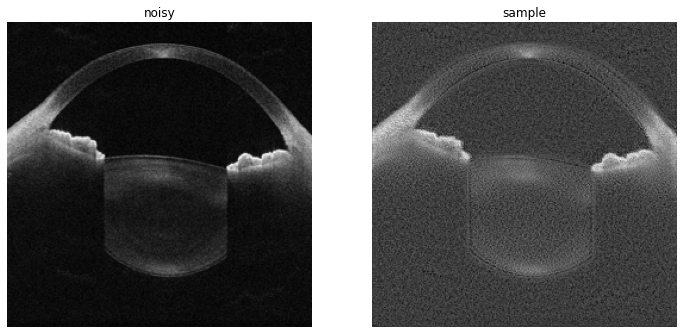

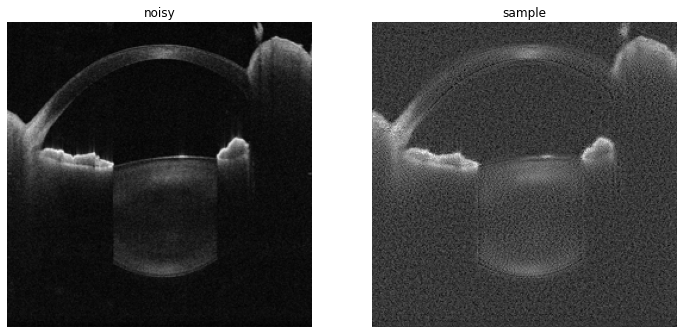

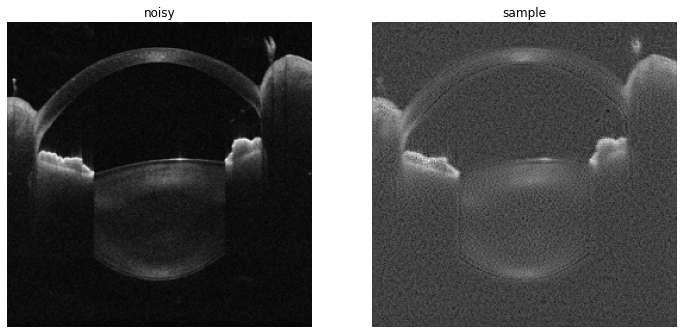

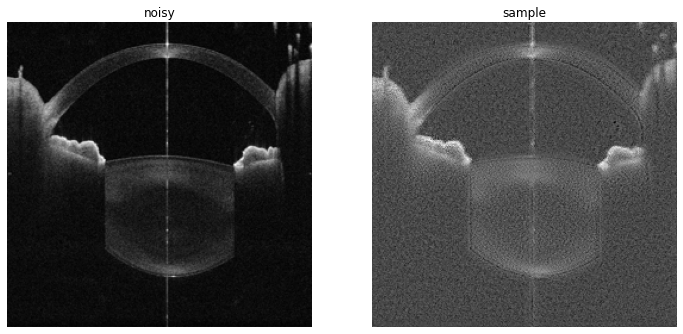

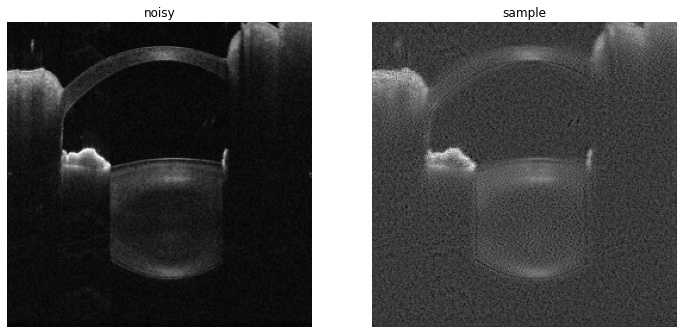

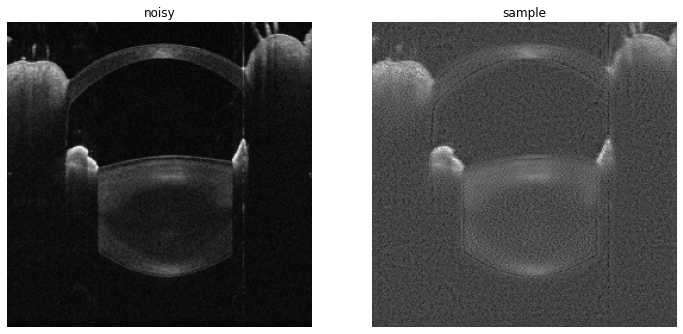

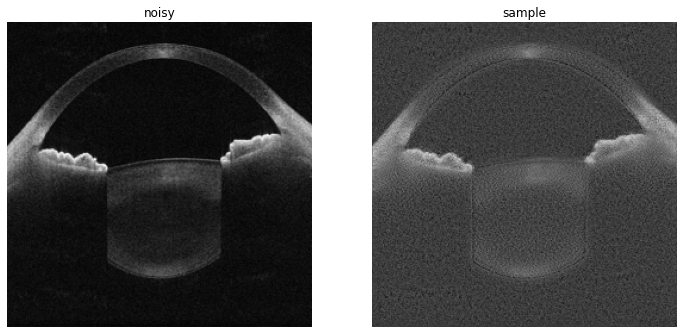

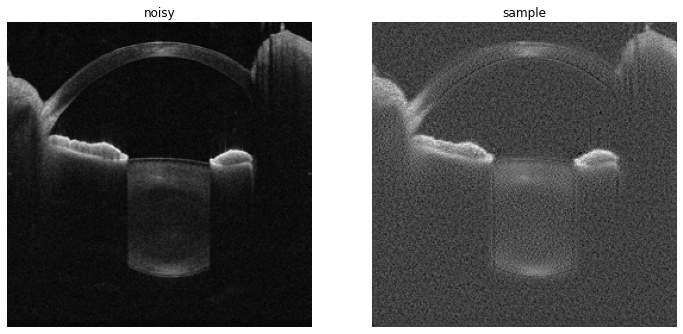

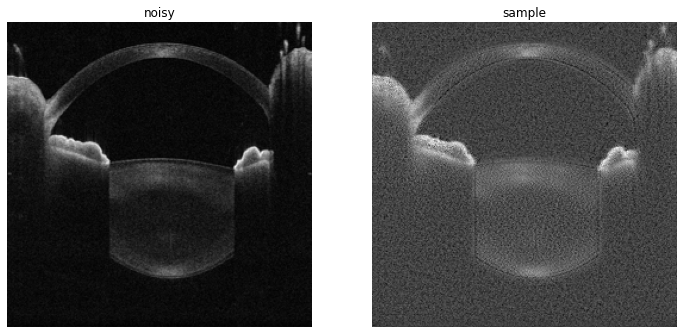

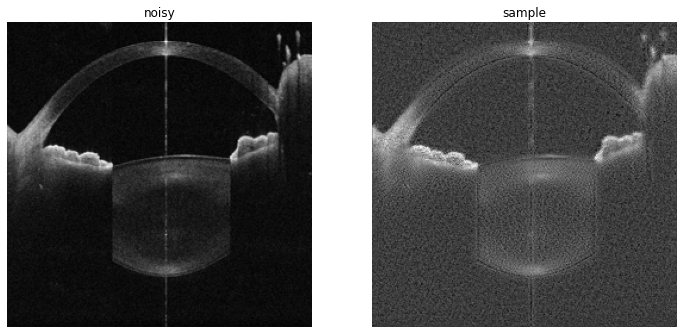

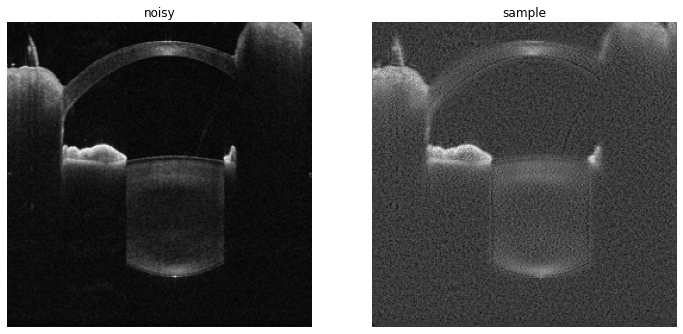

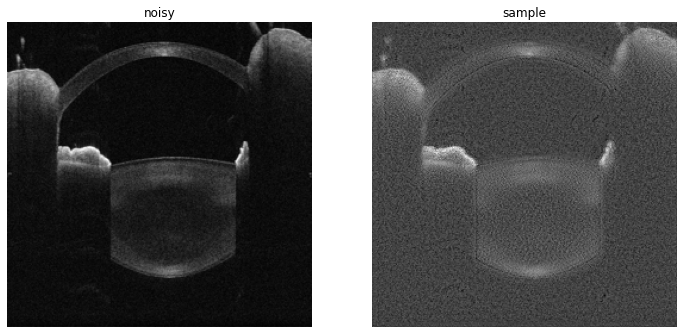

In [ ]:
from DDPM_GaussianDiffusion import GaussianDiffusion, get_beta_schedule
vol_dn = np.zeros([len(test_data), 256, 256], dtype=np.float32)

for step, x in enumerate(test_data):
    with torch.no_grad():
        sample = GaussianDiffusion(betas=betas, device=device)
        x0 = x.to(device)
        t = 48

        eps_t = model(x0, torch.tensor([t]).to(device)) #预测噪声
        x0_pred = sample.denoise(x0, eps_t, t) # 从预测出的噪声中还原xt-1

        im_0 = GaussianDiffusion._to_nparray_(x0_pred, transpose=False)
        im_orig = GaussianDiffusion._to_nparray_(x0, transpose=False)

        vol_dn[step, :, :] = im_0

        if step % 1 == 0:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1), plt.imshow(im_orig, cmap='gray'), plt.axis('off'), plt.title('noisy')
            plt.subplot(1, 2, 2), plt.imshow(im_0, cmap='gray'), plt.axis('off'), plt.title('sample')
            plt.show()


util.nii_saver(np.transpose(vol_dn, [2, 1, 0]), "C:\\Users\\Lenovo\\Desktop\\Diffusion Model\\OCT_DDPM\\saved_nii\\", "DDPM_.nii.gz")
#        